In [2]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
from sklearn.metrics import classification_report, recall_score,precision_score,accuracy_score,f1_score
import pathlib
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc, melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from research.dataImporting import MLtools
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, Conv2D, SeparableConv1D, MaxPooling1D,MaxPooling2D, Flatten, Dense, Dropout, AlphaDropout, \
    BatchNormalization, Activation, LSTM, Lambda, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from research.dataImporting import dataTools
import keras.backend as K
from tcn import TCN
from keras import regularizers

# Hot pile of shit that explored using different configurations for input (ex. signifying that "drone" is anything within 60m"), as well as exploring using melspectrograms for DFP

In [37]:
training_df_raw=pd.read_csv(r"C:\Users\rclendening\PycharmProjects\MLTesting\research\research\localization\LT80m_detection_training_w_matrice_phantom_augment_A1_A2_A3.csv")

In [64]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5"]
good_runs_mavic=["A2R7P1","A2R7P2","A2R7P3","A2R7P4","A2R7P5","A2R8P1","A2R8P2","A2R8P3","A2R8P4","A2R8P5","A3R6P1"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A2_A3_training_w_Matrice_Phantom.csv")
x_data=[]
y_data=[]
total_ranges=[]
aug_vals=[7000,7200,7400,7600,7800,8000,8200,8400,8600,8800,9000]

def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    spect = melspectrogram(y=data,sr=Fs)
    return spect
def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    coefs = mfcc(y=data, hop_length=1024,n_mfcc=40, sr=Fs)
    return coefs
x_data=[]
y_data=[]
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    if scenario== "A3":
        for x in aug_vals:
            full_aug_name=full_name+"_"+str(x).strip()
            print(full_aug_name)
            pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_aug_name]
            max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
        # if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom or full_name in good_runs_mavic:
            for phone in phone_slots:
                phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
                twd_frame=[]
                range_frame=[]
                for i in range(0,max_segment):
                    frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
                    data=np.array(frame_df.iloc[:,8:48])
                    if np.any(data):
                        mel_data=data[0]
                    dist=frame_df[str(notable_col_names.index('Range'))]
                    distance_val=np.array(dist)
                #dist=phone_seg["Range"]
                    if len(distance_val)>0:
                        dist=distance_val[0]
                        if dist<78:
                            #data=data[0]
                            total_ranges.append(dist)
                            #data=np.reshape(data,(64,4))
                            #data=np.reshape(data,(40,1))
                            class_value=1
                            twd_frame.append(np.squeeze(mel_data))
                            range_frame.append(class_value)
                        elif 82< dist <140 or 500< dist <525:
                            #data=np.reshape(data,(64,4))
                            #data=np.reshape(data,(40,1))
                            class_value=0
                            twd_frame.append(np.squeeze(mel_data))
                            range_frame.append(class_value)
                #y_vals= rangeClosest(range_frame)
                x_data.extend(twd_frame)
                y_data.extend(range_frame)
    # if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom or full_name in good_runs_mavic:
    else:
        print(full_name)
        pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
        max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
            twd_frame=[]
            range_frame=[]
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
                data=np.array(frame_df.iloc[:,8:48])
                if np.any(data):
                    mel_data=data
                dist=frame_df[str(notable_col_names.index('Range'))]
                distance_val=np.array(dist)
            #dist=phone_seg["Range"]
                if len(distance_val)>0:
                    if distance_val<78:
                        data=data[0]
                        total_ranges.append(distance_val.squeeze())
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=1
                        twd_frame.append(np.squeeze(mel_data))
                        range_frame.append(class_value)
                    elif 82< distance_val <140 or 500< distance_val <525:
                        data=data[0]
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=0
                        twd_frame.append(np.squeeze(mel_data))
                        range_frame.append(class_value)
            #y_vals= rangeClosest(range_frame)
            x_data.extend(twd_frame)
            y_data.extend(range_frame)
    # plt.hist(np.array(total_ranges).squeeze(),bins=50)
    # plt.figure()

A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A3R3P1_7000
A3R3P1_7200
A3R3P1_7400
A3R3P1_7600
A3R3P1_7800
A3R3P1_8000
A3R3P1_8200
A3R3P1_8400
A3R3P1_8600
A3R3P1_8800
A3R3P1_9000
A3R3P4_7000
A3R3P4_7200
A3R3P4_7400
A3R3P4_7600
A3R3P4_7800
A3R3P4_8000
A3R3P4_8200
A3R3P4_8400
A3R3P4_8600
A3R3P4_8800
A3R3P4_9000
A3R3P5_7000
A3R3P5_7200
A3R3P5_7400
A3R3P5_7600
A3R3P5_7800
A3R3P5_8000
A3R3P5_8200
A3R3P5_8400
A3R3P5_8600
A3R3P5_8800
A3R3P5_9000
A3R4P4_7000
A3R4P4_7200
A3R4P4_7400
A3R4P4_7600
A3R4P4_7800
A3R4P4_8000
A3R4P4_8200
A3R4P4_8400
A3R4P4_8600
A3R4P4_8800
A3R4P4_9000
A3R4P5_7000
A3R4P5_7200
A3R4P5_7400
A3R4P5_7600
A3R4P5_7800
A3R4P5_8000
A3R4P5_8200
A3R4P5_8400
A3R4P5_8600
A3R4P5_8800
A3R4P5_9000
A3R6P1_7000
A3R6P1_7200
A3R6P1_7400
A3R6P1_7600
A3R6P1_7800
A3R6P1_8000
A3R6P1_8200
A3R6P1_8400
A3R6P1_8600
A3R6P1_8800
A3R6P1_9000


Text(0, 0.5, 'Count')

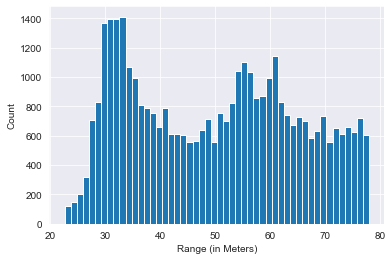

In [62]:
plt.hist(np.array(total_ranges).squeeze(),bins=50)
plt.xlabel("Range (in Meters)")
plt.ylabel("Count")
#plt.savefig("./Plots/cellphone_training_ranges_hist_LT80.pdf",bbox_inches="tight")

In [5]:
a=x_data
b=y_data

Text(0.5, 0, 'Class Distribution (0=Noise, 1=sUAS)')

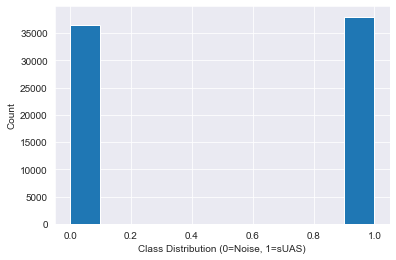

In [65]:
plt.hist(y_data)
plt.ylabel("Count")
plt.xlabel("Class Distribution (0=Noise, 1=sUAS)")
#plt.savefig("./Plots/cellphone_training_distro_hist.pdf",bbox_inches="tight")

In [49]:
y_data_copy=y_data
x_data_copy=x_data
y_data_copy.extend(labels[:,0])
x_data_copy.extend(features)
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=2,size=1)
        if y_data[x]==0 and rand_vals==1:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x]==1:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
def subsamplesUAS(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=4,size=1)
        if y_data[x]==0 and rand_vals!=1:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x]==1:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)

In [7]:
# training_data=pd.read_csv("training_df_LT80m.csv")
# mean_std=pd.read_csv("mean_std_training_ds.csv")

(array([36529.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 37987.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

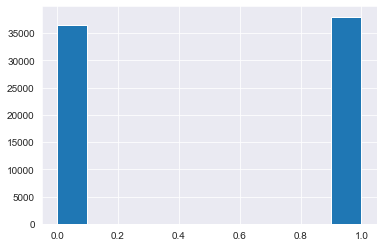

In [66]:
# y_data=np.array(training_data.iloc[:,1])
# x_data=np.array(training_data.iloc[:,2:42])
# mean=np.array(mean_std.loc[:,'mean'])
# std=np.array(mean_std.loc[:,'std'])
# x_data=np.array(x_data_copy)
# y_data=np.array(y_data_copy)
train_feats,test_feats,train_targs,test_targs=train_test_split(x_data,y_data,test_size=0.2,shuffle=True,random_state=42)
train_feats=np.array(train_feats)
train_targs=np.array(train_targs)
test_feats=np.array(test_feats)
test_targs=np.array(test_targs)
mean = train_feats.mean(axis=0)
std = train_feats.std(axis=0)
train_feats -= mean
train_feats /= std
test_feats -= mean
test_feats /= std
plt.hist(y_data)

(array([14783.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 13661.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

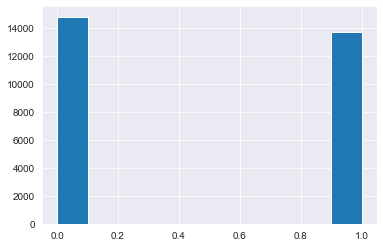

In [8]:
plt.hist(train_targs)

In [73]:
training_df=pd.DataFrame(x_data)
truth_labels_df=pd.DataFrame(y_data)
training_df_full=pd.concat([truth_labels_df,training_df],axis=1)
training_df_full.to_csv("training_df_LT80m_wo_A1_augmented.csv")
print(mean)
print(std)
stdizer=pd.DataFrame([mean,std]).transpose()
stdizer.columns=['mean','std']
stdizer.to_csv("mean_std_training_ds_wo_A1_augmented.csv")

[-211.01051126  134.74451276    6.76320756   51.22421017  -10.17536288
   24.2854556   -14.09551452   11.04095832   -5.61551928    6.57147988
    0.33927969   -0.58139846    2.17701933   -4.32935913    0.65458101
   -5.6254182    -0.26176269   -5.00660121   -1.41353455   -4.76414788
   -3.16503782   -3.63606912   -2.80188345   -1.10907331   -1.52436603
   -1.05422401   -3.43769365   -2.24130013   -3.62191407   -2.54361015
   -3.81219837   -2.54111547   -3.0195617    -2.86566864   -2.7501617
   -3.13762002   -2.39018639   -3.00760036   -1.44463956   -1.98437526]
[85.36242542 21.60615108 27.83851796 18.01986866 17.96673122 14.03814584
 13.72438291 12.75008839 10.95433398 11.08115162 10.56739421  9.1343852
  8.77165367  7.25372442  7.53985822  6.99814273  7.355323    6.67823676
  6.88200989  6.76108589  6.05737388  6.20767233  6.56326216  7.11331127
  6.36228581  6.96765783  6.56902763  5.30635228  5.08794344  4.94855881
  4.6673294   4.84993676  4.71548713  4.95042705  5.42160248  5.1133

# Naive

In [44]:
print(precision_score(test_targs,np.zeros(len(test_targs))))
print(recall_score(test_targs,np.zeros(len(test_targs))))
print(accuracy_score(test_targs,np.zeros(len(test_targs))))
print(f1_score(test_targs,np.zeros(len(test_targs))))

0.0
0.0
0.5528130250883597
0.0


C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LDA / QDA

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
lda= LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lda.fit(train_feats,train_targs)
qda.fit(train_feats,train_targs)

QuadraticDiscriminantAnalysis()

In [68]:
ldaPreds=lda.predict(test_feats)
qdaPreds=qda.predict(test_feats)
print(accuracy_score(test_targs,ldaPreds))
print(precision_score(test_targs,ldaPreds))
print(recall_score(test_targs,ldaPreds))
print(f1_score(test_targs,ldaPreds))

0.668545356951154
0.665064935064935
0.6844426623897354
0.67461467527335


In [69]:
import pickle
filename = 'finalized_qda_model.sav'
pickle.dump(qda, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))

# SVM

(array([10357.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  9553.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

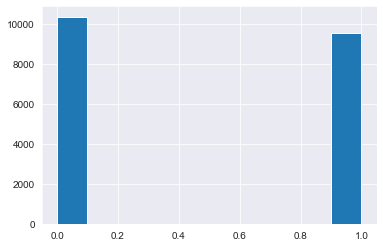

In [111]:
svmTrain_feats,_,svmTrain_targs,__=train_test_split(train_feats,train_targs,test_size=0.3,shuffle=True,random_state=42)
plt.hist(svmTrain_targs)

In [12]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

model = svm.SVC(kernel='rbf')
pipeline= Pipeline([('estimator', model)])
cv = KFold(n_splits=5)
param_grid= {
    'estimator__C':[0.1,1,10,100], 'estimator__gamma':[1,0.1,0.01]}

search = GridSearchCV(pipeline, param_grid,refit=True,verbose=3, n_jobs=-1)
print(search.fit(train_feats,train_targs))
print(search.best_params_)
print(search.best_score_)
search.score(test_feats,test_targs)
SVMmodelPreds=search.predict(test_feats)
print(precision_score(test_targs,SVMmodelPreds))
print(recall_score(test_targs,SVMmodelPreds))
print(accuracy_score(test_targs,SVMmodelPreds))
print(f1_score(test_targs,SVMmodelPreds))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV(estimator=Pipeline(steps=[('estimator', SVC())]), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10, 100],
                         'estimator__gamma': [1, 0.1, 0.01]},
             verbose=3)
{'estimator__C': 100, 'estimator__gamma': 0.1}
0.8894318223116192
0.8979414322992172
0.8815826928551096
0.8920134983127109
0.8896868715886239


In [74]:
import pickle
filename = 'finalized_svm_model.sav'
pickle.dump(search, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))

KeyboardInterrupt: 

# CNN Evaluation

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 160)               6560      
                                                                 
 alpha_dropout_4 (AlphaDropo  (None, 160)              0         
 ut)                                                             
                                                                 
 dense_4 (Dense)             (None, 80)                12880     
                                                                 
 alpha_dropout_5 (AlphaDropo  (None, 80)               0         
 ut)                                                             
                                                                 
 dense_55 (Dense)            (None, 40)                3240      
                                                                 
 dense_5 (Dense)             (None, 20)               

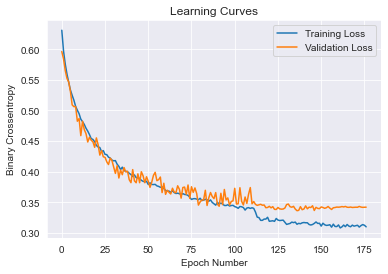

In [69]:
CNNv3=tf.keras.Sequential()
CNNv3.add(Input(shape=(40)))
CNNv3.add(Dense(160, activation='selu', name='dense_1',kernel_initializer='lecun_normal'))
CNNv3.add(AlphaDropout(0.3))
CNNv3.add(Dense(80, activation='selu', name='dense_4',kernel_initializer='lecun_normal'))
CNNv3.add(AlphaDropout(0.2))
# CNNv3.add(AlphaDropout(0.2))
CNNv3.add(Dense(40, activation='selu', name='dense_55',kernel_initializer='lecun_normal'))
CNNv3.add(Dense(20, activation='selu', name='dense_5',kernel_initializer='lecun_normal'))
CNNv3.add(Dense(20, activation='selu', name='dense_56',kernel_initializer='lecun_normal'))
CNNv3.add(Dense(10, activation='selu', name='dense_57',kernel_initializer='lecun_normal'))
CNNv3.add(Dense(1, activation='sigmoid', name='dense_6'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv3.summary()
CNNv3.compile(optimizer='nadam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
history = CNNv3.fit(train_feats, train_targs,
                      epochs=500,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()

In [70]:
CNNv3.evaluate(test_feats,test_targs)

466/466 [==============================] - 1s 1ms/step - loss: 0.3230 - accuracy: 0.8662


[0.3229907155036926, 0.866210401058197]

In [15]:
CNNpreds=CNNv3.predict(test_feats)
CNNpreds=CNNpreds>0.5

223/223 [==============================] - 0s 853us/step


In [71]:
CNNpreds=CNNv3.predict(test_feats)
CNNpreds=CNNpreds>0.5
print(precision_score(test_targs,CNNpreds))
print(recall_score(test_targs,CNNpreds))
print(accuracy_score(test_targs,CNNpreds))
print(f1_score(test_targs,CNNpreds))

466/466 [==============================] - 0s 824us/step
0.8643122676579925
0.8700882117080995
0.8662104133118625
0.8671906220860529


In [72]:
from research.dataImporting import MLtools
MLtools.save_model(CNNv3,"ANN_LT80_wo_A1_A3_aug_added")

# CNN Deep Version

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 80)                3280      
                                                                 
 alpha_dropout_2 (AlphaDropo  (None, 80)               0         
 ut)                                                             
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 alpha_dropout_3 (AlphaDropo  (None, 80)               0         
 ut)                                                             
                                                                 
 dense_3 (Dense)             (None, 80)                6480      
                                                                 
 dense_4 (Dense)             (None, 40)               

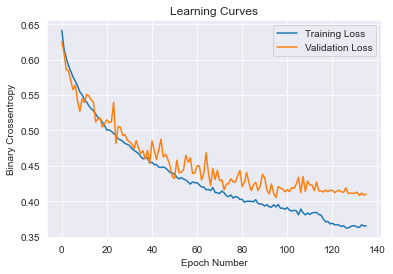

In [17]:
CNNv2=tf.keras.Sequential()
CNNv2.add(Input(shape=(40)))
CNNv2.add(Dense(80, activation='selu', name='dense_1',kernel_initializer='lecun_normal'))
CNNv2.add(AlphaDropout(0.3))
CNNv2.add(Dense(80, activation='selu', name='dense_2',kernel_initializer='lecun_normal'))
CNNv2.add(AlphaDropout(0.2))
CNNv2.add(Dense(80, activation='selu', name='dense_3',kernel_initializer='lecun_normal'))
# CNNv3.add(AlphaDropout(0.2))
CNNv2.add(Dense(40, activation='selu', name='dense_4',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(20, activation='selu', name='dense_5',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(20, activation='selu', name='dense_6',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(20, activation='selu', name='dense_7',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(10, activation='selu', name='dense_8',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(10, activation='selu', name='dense_9',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(5, activation='selu', name='dense_10',kernel_initializer='lecun_normal'))
CNNv2.add(Dense(1, activation='sigmoid', name='dense_11'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv2.summary()
CNNv2.compile(optimizer='nadam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
history = CNNv2.fit(train_feats, train_targs,
                      epochs=500,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()

In [75]:
CNNpredsv2=CNNv2.predict(test_feats)
CNNpredsv2=CNNpredsv2>0.5
print(precision_score(test_targs,CNNpredsv2))
print(recall_score(test_targs,CNNpredsv2))
print(accuracy_score(test_targs,CNNpredsv2))
print(f1_score(test_targs,CNNpredsv2))

NameError: name 'CNNv2' is not defined

# CNN Wide

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1024)              41984     
                                                                 
 alpha_dropout_4 (AlphaDropo  (None, 1024)             0         
 ut)                                                             
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 alpha_dropout_5 (AlphaDropo  (None, 512)              0         
 ut)                                                             
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 alpha_dropout_6 (AlphaDropo  (None, 256)             

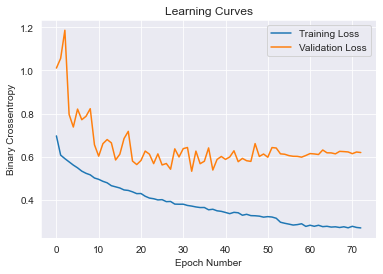

In [19]:
CNNv1=tf.keras.Sequential()
CNNv1.add(Input(shape=(40)))
CNNv1.add(Dense(1024, activation='selu', name='dense_1',kernel_initializer='lecun_normal'))
CNNv1.add(AlphaDropout(0.5))
CNNv1.add(Dense(512, activation='selu', name='dense_2',kernel_initializer='lecun_normal'))
CNNv1.add(AlphaDropout(0.4))
CNNv1.add(Dense(256, activation='selu', name='dense_3',kernel_initializer='lecun_normal'))
CNNv1.add(AlphaDropout(0.3))
CNNv1.add(Dense(1, activation='sigmoid', name='dense_6'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv1.summary()
CNNv1.compile(optimizer='nadam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
history = CNNv1.fit(train_feats, train_targs,
                      epochs=500,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()

In [20]:
CNNv1preds=CNNv1.predict(test_feats)
CNNv1preds=CNNv1preds>0.5
print(precision_score(test_targs,CNNv1preds))
print(recall_score(test_targs,CNNv1preds))
print(accuracy_score(test_targs,CNNv1preds))
print(f1_score(test_targs,CNNv1preds))

223/223 [==============================] - 1s 3ms/step
0.8772905759162304
0.7631653857102192
0.8302868391451068
0.8162581823717461


In [ ]:
features = []
labels = []
dataset_path: str = "C:\\Users\\rclendening\\researchData\\YT_vids"
data_dir = pathlib.Path(dataset_path)
droneDict = {  # One hot encoding for labels probs should do it like I did below?
    "Drone": [1, 0],
    "Noise": [0, 1]
}
droneCountDict = {  # One hot encoding for labels
    "Noise": 0,
    "Drone": 1
}

dataCount = [0, 0]
train_files=[]
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        train_files.append(os.path.join(path, name))


def split_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (MFCC)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    # middle third of data
    duration = waveData.shape[0]
    startTime = np.round(0)
    endTime = np.round(duration)
    waveDataSplit= waveData[int(startTime):int(endTime)]
    features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
    dataCount[droneCountDict[labelName]] += features.shape[1]
    #label= [droneDict[labelName]] * features.shape[1]
    label= [droneCountDict[labelName]]*features.shape[1]
    return features, label

def create_dataset(train_files):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    i = 0
    features = []
    labels = []
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if str.split(x,"\\")[6][0] == 'y': #if youtube video mark yt as true
            yt=1
        else:
            yt=0
        test_audio, sampleRate = librosa.load(x, sr=8000)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)!=0:
            x = str(x)
            label = x.split('\\')
            label = label[5]
            newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            newFeats, newLabs = split_audio(newData, label, int(sampleRate))
            features.extend(newFeats.transpose())
            newLabs=list(zip(newLabs, np.ones(len(newLabs))*yt))
            labels.extend(newLabs)

    return features, labels

def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=1024,n_mfcc=40, sr=Fs)
    return coefs

def grabTrainingSamples(n, trainingData):
    '''
    Ensures even training set by grabbing an even amount of training samples from each class.
    @param n: limiting class count
    @param trainingData: trainingData list that includes both features and labels
    @return MFCC coefficients
    '''
    droneCount=0
    noiseCount=0
    evenTrainingData = []
    evenLabelData = []
    for i in range(len(labels)):
        lab = trainingData[i][1][0]
        if lab == 1 and droneCount < n:
            droneCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(trainingData[i][1])
        elif lab == 0 and noiseCount < n:
            noiseCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(trainingData[i][1])
    return evenTrainingData, evenLabelData

Fs = 8000
numFeat = 40 #COULD BE SOURCE OF ERROR
features, labels = create_dataset(train_files)
newSet = list(zip(features, labels))
random.seed(42)
random.shuffle(newSet)  # Ensure data is mixed together
n = np.min(dataCount)  # Ensure data is symmetric (aka even amounts of training data for all classes)
# features, labels = grabTrainingSamples(n, features, labels)
#features, labels = grabTrainingSamples(n, newSet)
labels=to_categorical(np.array(labels)[:,0],num_classes=2)
# trainFeatures, testFeatures, trainTargets, testTargets = train_test_split(features, labels, test_size=0.2, random_state=42) #changed to speed up training
# trainTargets=np.array(trainTargets)
# trainFeatures = np.array(trainFeatures)
# testTargets=np.array(testTargets)
# testFeatures = np.array(testFeatures)
# mean = trainFeatures.mean(axis=0)
# trainFeatures -= mean
# std = trainFeatures.std(axis=0)
# trainFeatures /= std
# trainFeatures = np.reshape(trainFeatures,
#                            (len(trainFeatures), numFeat, 1))
# #testFeatures = np.asarray(testFeatures)
# testFeatures -= mean
# testFeatures /= std
# testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))